In [1]:
import sys
sys.path.pop(0)

'/Library/Python/2.7/site-packages'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#import statsmodels.api as sm
#import statsmodels.stats.api as sms
#import statsmodels.formula.api as smf
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [112]:
sys.path.append('/Library/Python/2.7/site-packages')

In [3]:
df_train_orig = pd.read_csv('data/churn_train.csv')
df_test_orig = pd.read_csv('data/churn_test.csv')

In [9]:
df_train_orig.shape

(40000, 12)

In [17]:
type(df_train_orig.last_trip_date[0])

str

In [8]:
df_train_orig.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [5]:
def check_nan(df, cols):
    for c in cols:
        if sum(df[c].isnull())>0:
            print (c , ' has ' , sum(df[c].isnull()) , 'null/NAN values')
    return True

In [6]:
check_nan(df_train_orig, df_train_orig.columns)

avg_rating_by_driver  has  162 null/NAN values
avg_rating_of_driver  has  6528 null/NAN values
phone  has  319 null/NAN values


True

In [7]:
check_nan(df_test_orig, df_test_orig.columns)

avg_rating_by_driver  has  39 null/NAN values
avg_rating_of_driver  has  1594 null/NAN values
phone  has  77 null/NAN values


True

## Data Cleaning

In [133]:
df_train_orig = pd.read_csv('data/churn_train.csv')
df_test_orig = pd.read_csv('data/churn_test.csv')

df_train = df_train_orig
df_test = df_test_orig

df_train['last_trip_date_ym'] = df_train['last_trip_date'].apply(lambda x: x[:-3])
# general target label column
df_train['churn'] = (df_train['last_trip_date_ym']!='2014-06')&(df_train['last_trip_date_ym']!='2014-07')

# generate duration column
from datetime import datetime
df_train['signup_date_new'] = pd.to_datetime(df_train['signup_date'])
df_train['member_duration'] = pd.to_datetime('2014-07-01')-df_train['signup_date_new']
df_train['member_duration'] = df_train['member_duration'].dt.days

df_test['signup_date_new'] = pd.to_datetime(df_test['signup_date'])
df_test['member_duration'] = pd.to_datetime('2014-07-01')-df_test['signup_date_new']
df_test['member_duration'] = df_test['member_duration'].dt.days

def brutal_fillna(df):
    for c in df.columns:
        if sum(df[c].isnull())>0:
            cond = df[c].notnull()
            if df[c].dtype=='object':
                new_val = df[cond].groupby([c])[c].count().sort_values(ascending=False)[0]
            else:
                new_val = df[cond][c].mean()
            df[c]=df[c].fillna(new_val)
    return df

df_train = brutal_fillna(df_train_orig)
df_test = brutal_fillna(df_test_orig)

In [13]:
df_test = brutal_fillna(df_test_orig)

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33132 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  33132 non-null float64
avg_rating_by_driver      33132 non-null float64
avg_rating_of_driver      33132 non-null float64
avg_surge                 33132 non-null float64
city                      33132 non-null object
last_trip_date            33132 non-null object
phone                     33132 non-null object
signup_date               33132 non-null object
surge_pct                 33132 non-null float64
trips_in_first_30_days    33132 non-null int64
luxury_car_user           33132 non-null bool
weekday_pct               33132 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.1+ MB


In [21]:
df_train['last_trip_date_ym'] = df_train['last_trip_date'].apply(lambda x: x[:-3])

/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
dr_train_new = df_train

In [24]:
dr_train_new.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,last_trip_date_ym
0,6.94,5.0,5.0,1.0,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0,2014-05
1,8.06,5.0,5.0,1.0,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0,2014-01
6,4.87,4.7,4.0,1.0,Astapor,2014-04-21,Android,2014-01-18,0.0,0,False,66.7,2014-04
7,1.78,4.0,5.0,1.0,Winterfell,2014-01-12,iPhone,2014-01-11,0.0,3,False,0.0,2014-01
8,6.87,5.0,4.7,1.0,Astapor,2014-01-30,Android,2014-01-01,0.0,3,False,66.7,2014-01


In [34]:
dr_train_new['last_trip_date_ym'].unique()

array(['2014-05', '2014-01', '2014-04', '2014-06', '2014-03', '2014-02',
       '2014-07', nan], dtype=object)

In [35]:
dr_train_new['churn'] = (dr_train_new['last_trip_date_ym']=='2014-06')|(dr_train_new['last_trip_date_ym']=='2014-07')

/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
dr_train_new.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,last_trip_date_ym,churn
0,6.94,5.0,5.0,1.0,Astapor,2014-05-03,Android,2014-01-12,0.0,0.0,0.0,100.0,2014-05,False
1,8.06,5.0,5.0,1.0,Astapor,2014-01-26,Android,2014-01-25,0.0,2.0,1.0,0.0,2014-01,False
6,4.87,4.7,4.0,1.0,Astapor,2014-04-21,Android,2014-01-18,0.0,0.0,0.0,66.7,2014-04,False
7,1.78,4.0,5.0,1.0,Winterfell,2014-01-12,iPhone,2014-01-11,0.0,3.0,0.0,0.0,2014-01,False
8,6.87,5.0,4.7,1.0,Astapor,2014-01-30,Android,2014-01-01,0.0,3.0,0.0,66.7,2014-01,False


### Check class balance

In [37]:
1.*sum(dr_train_new['churn']==True)/len(dr_train_new['churn'])

0.41049708749585007

In [154]:
1.*sum(df_train.churn)/len(df_train.churn)

0.6242

In [135]:
df_test.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,signup_date_new,member_duration
0,2.48,5.0,5.000000,1.0,Winterfell,2014-01-07,Android,2014-01-06,0.0,2,True,100.0,2014-01-06,176
1,10.81,5.0,5.000000,1.0,Winterfell,2014-04-29,iPhone,2014-01-06,0.0,3,True,100.0,2014-01-06,176
2,12.95,5.0,5.000000,1.0,Astapor,2014-01-29,Android,2014-01-19,0.0,1,True,100.0,2014-01-19,163
3,3.92,5.0,4.601011,1.0,Winterfell,2014-02-16,iPhone,2014-01-09,0.0,0,False,0.0,2014-01-09,173
4,1.46,5.0,4.500000,1.0,Astapor,2014-01-09,iPhone,2014-01-07,0.0,2,False,100.0,2014-01-07,175


In [136]:
train_feature_round1 = ['churn','member_duration','avg_dist', 'phone', 'city', 'luxury_car_user', 'trips_in_first_30_days', 'surge_pct']
test_feature_round1 = ['member_duration','avg_dist', 'phone', 'city', 'luxury_car_user', 'trips_in_first_30_days', 'surge_pct']

In [137]:
df_train_round1 = df_train[train_feature_round1]
df_test_round1 = df_test[test_feature_round1]

**merge train and test and dummified**

In [138]:
train_len = len(df_train)
master_set_round1 =  pd.concat(objs=[df_train_round1, df_test_round1], axis=0).reset_index(drop=True)

In [139]:
# dummy phone, city, luxary
master_set_round1 = pd.concat([master_set_round1, pd.get_dummies(master_set_round1['phone'])], axis=1)
master_set_round1 = pd.concat([master_set_round1, pd.get_dummies(master_set_round1['city'])], axis=1)
master_set_round1['luxury_car_user'] = master_set_round1['luxury_car_user'].map({True: 1, False: 0})
#master_set_round1 = pd.concat([master_set_round1, pd.get_dummies(master_set_round1['luxury_car_user'])], axis=1)
master_set_round1.drop(['phone','city'], axis=1, inplace=True)

In [140]:
master_set_round1.head()

,avg_dist,churn,luxury_car_user,member_duration,surge_pct,trips_in_first_30_days,6954,27628,Android,iPhone,Astapor,King's Landing,Winterfell
0,6.94,True,0,170,0.0,0,0,0,1,0,1,0,0
1,8.06,True,1,157,0.0,2,0,0,1,0,1,0,0
2,21.50,True,1,180,0.0,1,0,0,0,1,0,0,1
3,9.46,True,0,173,100.0,1,0,0,1,0,0,0,1
4,13.77,True,0,151,0.0,0,0,0,0,1,0,0,1


In [120]:
df_train_round1_new = master_set_round1[:train_len]
df_test_round1_new = master_set_round1[train_len:]
df_test_round1_new.drop('churn', axis=1, inplace=True)

/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
df_train_round1_new.head()

,avg_dist,churn,luxury_car_user,member_duration,surge_pct,trips_in_first_30_days,6954,27628,Android,iPhone,Astapor,King's Landing,Winterfell
0,6.94,True,0,170,0.0,0,0,0,1,0,1,0,0
1,8.06,True,1,157,0.0,2,0,0,1,0,1,0,0
2,21.50,True,1,180,0.0,1,0,0,0,1,0,0,1
3,9.46,True,0,173,100.0,1,0,0,1,0,0,0,1
4,13.77,True,0,151,0.0,0,0,0,0,1,0,0,1


In [122]:
df_test_round1_new.head()

,avg_dist,luxury_car_user,member_duration,surge_pct,trips_in_first_30_days,6954,27628,Android,iPhone,Astapor,King's Landing,Winterfell
40000,2.48,1,176,0.0,2,0,0,1,0,0,0,1
40001,10.81,1,176,0.0,3,0,0,0,1,0,0,1
40002,12.95,1,163,0.0,1,0,0,1,0,1,0,0
40003,3.92,0,173,0.0,0,0,0,0,1,0,0,1
40004,1.46,0,175,0.0,2,0,0,0,1,1,0,0


In [123]:
X_train_round1 = df_train_round1_new[df_train_round1_new.drop('churn', axis =1).columns]
y_train_round1 = df_train_round1_new['churn'].map({True: 1, False: 0})

In [87]:
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler()
#X_resampled_round1, y_resampled_round1 = ros.fit_sample(X_train_round1, y_train_round1)

**Grid Search for RF modeling**

In [71]:
## Grid Search CV for Random Forest

random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100],
                      'random_state': [1]}
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
rf_gridsearch.fit(X_train_round1, y_train_round1)

print ("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  6.1min finished


best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 1}


In [75]:
cross_val_score(best_rf_model, X_train_round1, y_train_round1, cv = 11, scoring = 'roc_auc').mean()

0.80514313893721123

In [63]:
len(X_train_round1.columns)

12

### Plot feature importance according to RF model

[ 0.26703192  0.21550587  0.13208823  0.1156894   0.07775522  0.06069265
  0.04415547  0.03753495  0.03217036  0.01664409  0.00073184  0.        ]


(-1, 10)

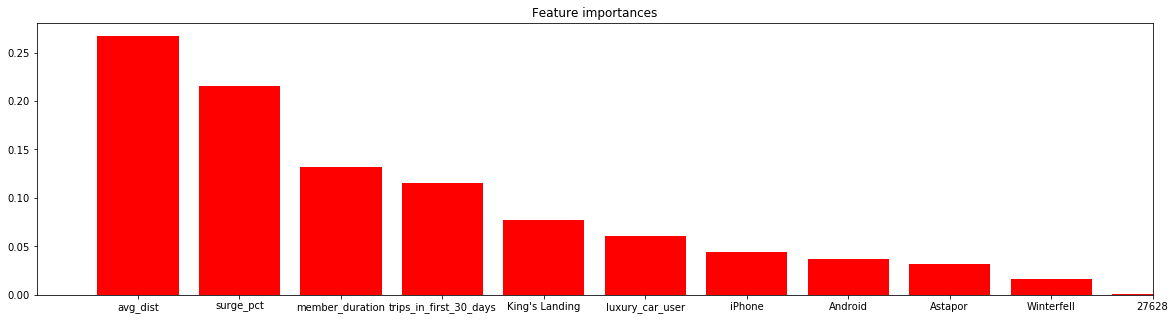

In [76]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train_round1.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(12), importances[indices], color="r", align="center")
plt.xticks(range(12), feature_names)
plt.xlim([-1, 10])


**Gradient Boosting Classifier modeling**

In [124]:
## Grid Search for GB Classification

gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02],
                          'loss': ['deviance', 'exponential'],
                          'max_depth': [2, 4],
                          'min_samples_leaf': [1, 2, 5],
                          'max_features': [1.0, 0.5],
                          'n_estimators': [100],
                          'random_state': [1]}
gbclf_gridsearch = GridSearchCV(GradientBoostingClassifier(), 
                              gradient_boosting_grid,
                              n_jobs=-1,
                              scoring='roc_auc')
gbclf_gridsearch.fit(X_train_round1, y_train_round1)
print ("best parameters:", gbclf_gridsearch.best_params_)

best_gbclf_model = gbclf_gridsearch.best_estimator_


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10a061660, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/ziru/anaconda/envs/py3/lib/python3.6/site...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/ziru/.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10a061660, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/ziru/anaconda/envs/py3/lib/python3.6/site...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/ziru/.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '## Grid Search for GB Classification\n\ngradient_b...t_gbclf_model = gbclf_gridsearch.best_estimator_\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 1, 23, 34, 50, 98063, tzinfo=datetime.timezone.utc), 'msg_id': '369C4A4C11314BFFA84C5EC5469301B9', 'msg_type': 'execute_request', 'session': 'EF3CD025307D43388B75A6F169388B76', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '369C4A4C11314BFFA84C5EC5469301B9', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'EF3CD025307D43388B75A6F169388B76']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '## Grid Search for GB Classification\n\ngradient_b...t_gbclf_model = gbclf_gridsearch.best_estimator_\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 1, 23, 34, 50, 98063, tzinfo=datetime.timezone.utc), 'msg_id': '369C4A4C11314BFFA84C5EC5469301B9', 'msg_type': 'execute_request', 'session': 'EF3CD025307D43388B75A6F169388B76', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '369C4A4C11314BFFA84C5EC5469301B9', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'EF3CD025307D43388B75A6F169388B76'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '## Grid Search for GB Classification\n\ngradient_b...t_gbclf_model = gbclf_gridsearch.best_estimator_\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 1, 23, 34, 50, 98063, tzinfo=datetime.timezone.utc), 'msg_id': '369C4A4C11314BFFA84C5EC5469301B9', 'msg_type': 'execute_request', 'session': 'EF3CD025307D43388B75A6F169388B76', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '369C4A4C11314BFFA84C5EC5469301B9', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='## Grid Search for GB Classification\n\ngradient_b...t_gbclf_model = gbclf_gridsearch.best_estimator_\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '## Grid Search for GB Classification\n\ngradient_b...t_gbclf_model = gbclf_gridsearch.best_estimator_\n'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('## Grid Search for GB Classification\n\ngradient_b...t_gbclf_model = gbclf_gridsearch.best_estimator_\n',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('## Grid Search for GB Classification\n\ngradient_b...t_gbclf_model = gbclf_gridsearch.best_estimator_\n',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='## Grid Search for GB Classification\n\ngradient_b...t_gbclf_model = gbclf_gridsearch.best_estimator_\n', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>], cell_name='<ipython-input-124-42bc4c340b1a>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1123a2f60, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1a49447300, file "<ipython-input-124-42bc4c340b1a>", line 14>
        result = <ExecutionResult object at 1123a2f60, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1a49447300, file "<ipython-input-124-42bc4c340b1a>", line 14>, result=<ExecutionResult object at 1123a2f60, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1a49447300, file "<ipython-input-124-42bc4c340b1a>", line 14>
        self.user_global_ns = {'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import sys\nsys.path.pop(0)', "import matplotlib.pyplot as plt\nimport pandas as...earchCV\n\nget_ipython().magic('matplotlib inline')", "df_train_orig = pd.read_csv('data/churn_train.cs...train_orig)\ndf_test = brutal_fillna(df_test_orig)", 'df_train.head()', 'df_test.head()', "train_feature_round1 = ['churn','member_duration...car_user', 'trips_in_first_30_days', 'surge_pct']", 'df_train_round1 = df_train[train_feature_round1]\ndf_test_round1 = df_test[test_feature_round1]', 'train_len = len(df_train)\nmaster_set_round1 =  p..., df_test_round1], axis=0).reset_index(drop=True)', "# dummy phone, city, luxary\nmaster_set_round1 = ...und1.drop(['phone','city'], axis=1, inplace=True)", 'master_set_round1.head()', "df_train_round1_new = master_set_round1[:train_l...st_round1_new.drop('churn', axis=1, inplace=True)", 'df_train_round1_new.head()', 'df_test_round1_new.head()', "X_train_round1 = df_train_round1_new[df_train_ro...rain_round1_new['churn'].map({True: 1, False: 0})", 'from imblearn.over_sampling import RandomOverSam... = ros.fit_sample(X_train_round1, y_train_round1)', '## Grid Search CV for Random Forest\n\nrandom_fore..._)\n\nbest_rf_model = rf_gridsearch.best_estimator_', "cross_val_score(best_rf_model, X_resampled_round...pled_round1, cv = 11, scoring = 'roc_auc').mean()", 'importances = best_rf_model.feature_importances_...ticks(range(9), feature_names)\nplt.xlim([-1, 10])', 'importances = best_rf_model.feature_importances_...ticks(range(9), feature_names)\nplt.xlim([-1, 10])', ...], 'Out': {1: '/Library/Python/2.7/site-packages', 4:    avg_dist  avg_rating_by_driver  avg_rating_of... 
4  False          2014-05-13               49  , 5:    avg_dist  avg_rating_by_driver  avg_rating_of...  153  
3              135  
4              173  , 10:    avg_dist  churn  luxury_car_user  member_dura...  0           1  
4               0           1  , 12:    avg_dist  churn  luxury_car_user  member_dura...  0           1  
4               0           1  , 13:        avg_dist  luxury_car_user  member_duratio...          1  
40004               0           0  , 17: 1.0, 23: 12, 24: (-1, 10), 27: <matplotlib.figure.Figure object>, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomOverSampler': <class 'imblearn.over_sampling.random_over_sampler.RandomOverSampler'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X_resampled_round1': array([[   6.94,    0.  ,  170.  , ...,    1.  ,... 0.  ,  177.  , ...,    0.  ,    0.  ,    1.  ]]), ...}
        self.user_ns = {'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import sys\nsys.path.pop(0)', "import matplotlib.pyplot as plt\nimport pandas as...earchCV\n\nget_ipython().magic('matplotlib inline')", "df_train_orig = pd.read_csv('data/churn_train.cs...train_orig)\ndf_test = brutal_fillna(df_test_orig)", 'df_train.head()', 'df_test.head()', "train_feature_round1 = ['churn','member_duration...car_user', 'trips_in_first_30_days', 'surge_pct']", 'df_train_round1 = df_train[train_feature_round1]\ndf_test_round1 = df_test[test_feature_round1]', 'train_len = len(df_train)\nmaster_set_round1 =  p..., df_test_round1], axis=0).reset_index(drop=True)', "# dummy phone, city, luxary\nmaster_set_round1 = ...und1.drop(['phone','city'], axis=1, inplace=True)", 'master_set_round1.head()', "df_train_round1_new = master_set_round1[:train_l...st_round1_new.drop('churn', axis=1, inplace=True)", 'df_train_round1_new.head()', 'df_test_round1_new.head()', "X_train_round1 = df_train_round1_new[df_train_ro...rain_round1_new['churn'].map({True: 1, False: 0})", 'from imblearn.over_sampling import RandomOverSam... = ros.fit_sample(X_train_round1, y_train_round1)', '## Grid Search CV for Random Forest\n\nrandom_fore..._)\n\nbest_rf_model = rf_gridsearch.best_estimator_', "cross_val_score(best_rf_model, X_resampled_round...pled_round1, cv = 11, scoring = 'roc_auc').mean()", 'importances = best_rf_model.feature_importances_...ticks(range(9), feature_names)\nplt.xlim([-1, 10])', 'importances = best_rf_model.feature_importances_...ticks(range(9), feature_names)\nplt.xlim([-1, 10])', ...], 'Out': {1: '/Library/Python/2.7/site-packages', 4:    avg_dist  avg_rating_by_driver  avg_rating_of... 
4  False          2014-05-13               49  , 5:    avg_dist  avg_rating_by_driver  avg_rating_of...  153  
3              135  
4              173  , 10:    avg_dist  churn  luxury_car_user  member_dura...  0           1  
4               0           1  , 12:    avg_dist  churn  luxury_car_user  member_dura...  0           1  
4               0           1  , 13:        avg_dist  luxury_car_user  member_duratio...          1  
40004               0           0  , 17: 1.0, 23: 12, 24: (-1, 10), 27: <matplotlib.figure.Figure object>, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomOverSampler': <class 'imblearn.over_sampling.random_over_sampler.RandomOverSampler'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X_resampled_round1': array([[   6.94,    0.  ,  170.  , ...,    1.  ,... 0.  ,  177.  , ...,    0.  ,    0.  ,    1.  ]]), ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/ziru/Galvanize/dsi-ml-case-study/<ipython-input-124-42bc4c340b1a> in <module>()
      9                           'random_state': [1]}
     10 gbclf_gridsearch = GridSearchCV(GradientBoostingClassifier(), 
     11                               gradient_boosting_grid,
     12                               n_jobs=-1,
     13                               scoring='roc_auc')
---> 14 gbclf_gridsearch.fit(X_train_round1, y_train_round1)
     15 print ("best parameters:", gbclf_gridsearch.best_params_)
     16 
     17 best_gbclf_model = gbclf_gridsearch.best_estimator_

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...core='warn',
       scoring='roc_auc', verbose=0), X=       avg_dist  luxury_car_user  member_duratio...       0           0  

[40000 rows x 12 columns], y=0        1
1        1
2        1
3        1
4   ...999    1
Name: churn, Length: 40000, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =        avg_dist  luxury_car_user  member_duratio...       0           0  

[40000 rows x 12 columns]
        y = 0        1
1        1
2        1
3        1
4   ...999    1
Name: churn, Length: 40000, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Dec  1 15:34:50 2017
PID: 48225           Python 3.6.1: /Users/ziru/anaconda/envs/py3/bin/python
...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False),        avg_dist  luxury_car_user  member_duratio...       0           0  

[40000 rows x 12 columns], 0        1
1        1
2        1
3        1
4   ...999    1
Name: churn, Length: 40000, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([13334, 13335, 13336, ..., 39997, 39998, 39999]), array([    0,     1,     2, ..., 13331, 13332, 13333]), 0, {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 1}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False),        avg_dist  luxury_car_user  member_duratio...       0           0  

[40000 rows x 12 columns], 0        1
1        1
2        1
3        1
4   ...999    1
Name: churn, Length: 40000, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([13334, 13335, 13336, ..., 39997, 39998, 39999]), array([    0,     1,     2, ..., 13331, 13332, 13333]), 0, {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 1})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), X=       avg_dist  luxury_car_user  member_duratio...       0           0  

[40000 rows x 12 columns], y=0        1
1        1
2        1
3        1
4   ...999    1
Name: churn, Length: 40000, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([13334, 13335, 13336, ..., 39997, 39998, 39999]), test=array([    0,     1,     2, ..., 13331, 13332, 13333]), verbose=0, parameters={'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 1}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseGradientBoosting.fit of Gradie...=1.0, verbose=0,
              warm_start=False)>
        X_train =        avg_dist  luxury_car_user  member_duratio...       0           0  

[26666 rows x 12 columns]
        y_train = 13334    1
13335    1
13336    1
13337    1
1333...999    1
Name: churn, Length: 26666, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py in fit(self=GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), X=array([[  13.19999981,    0.        ,  163.     ...      0.        ,    0.        ]], dtype=float32), y=array([0, 0, 0, ..., 0, 0, 0]), sample_weight=array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), monitor=None)
    986         check_consistent_length(X, y, sample_weight)
    987 
    988         y = self._validate_y(y)
    989 
    990         random_state = check_random_state(self.random_state)
--> 991         self._check_params()
        self._check_params = <bound method BaseGradientBoosting._check_params...=1.0, verbose=0,
              warm_start=False)>
    992 
    993         if not self._is_initialized():
    994             # init state
    995             self._init_state()

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py in _check_params(self=GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False))
    824             loss_class = LOSS_FUNCTIONS[self.loss]
    825 
    826         if self.loss in ('huber', 'quantile'):
    827             self.loss_ = loss_class(self.n_classes_, self.alpha)
    828         else:
--> 829             self.loss_ = loss_class(self.n_classes_)
        self.loss_ = undefined
        loss_class = <class 'sklearn.ensemble.gradient_boosting.BinomialDeviance'>
        self.n_classes_ = 1
    830 
    831         if not (0.0 < self.subsample <= 1.0):
    832             raise ValueError("subsample must be in (0,1] but "
    833                              "was %r" % self.subsample)

...........................................................................
/Users/ziru/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py in __init__(self=<sklearn.ensemble.gradient_boosting.BinomialDeviance object>, n_classes=1)
    467     fit one tree instead of ``n_classes`` trees.
    468     """
    469     def __init__(self, n_classes):
    470         if n_classes != 2:
    471             raise ValueError("{0:s} requires 2 classes.".format(
--> 472                 self.__class__.__name__))
        self.__class__.__name__ = 'BinomialDeviance'
    473         # we only need to fit one tree for binary clf.
    474         super(BinomialDeviance, self).__init__(1)
    475 
    476     def init_estimator(self):

ValueError: BinomialDeviance requires 2 classes.
___________________________________________________________________________

In [153]:
cross_val_score(best_gbclf_model, X_train_round1, y_train_round1, cv = 11, scoring = 'recall').mean()

0.88369094477939425

### Plotting feature importance according to GBC model

[ 0.24670254  0.23577351  0.19244277  0.09401131  0.06160754  0.0584646
  0.03940387  0.03903873  0.02008586  0.00946211  0.00300717  0.        ]


(-1, 10)

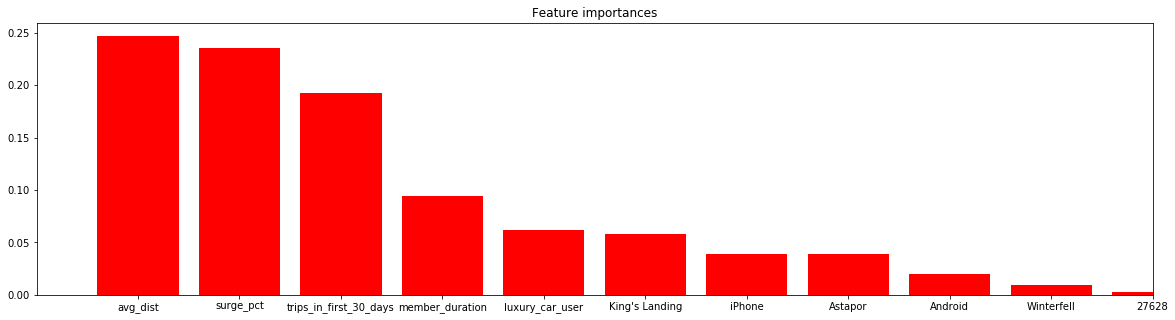

In [81]:
importances = best_gbclf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train_round1.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(12), importances[indices], color="r", align="center")
plt.xticks(range(12), feature_names)
plt.xlim([-1, 10])

In [84]:
X_train_round1.columns

Index([              'avg_dist',        'luxury_car_user',
              'member_duration',              'surge_pct',
       'trips_in_first_30_days',                     6954,
                          27628,                'Android',
                       'iPhone',                'Astapor',
               'King's Landing',             'Winterfell'],
      dtype='object')

### Another way to examine feature importance: partial dependence plot

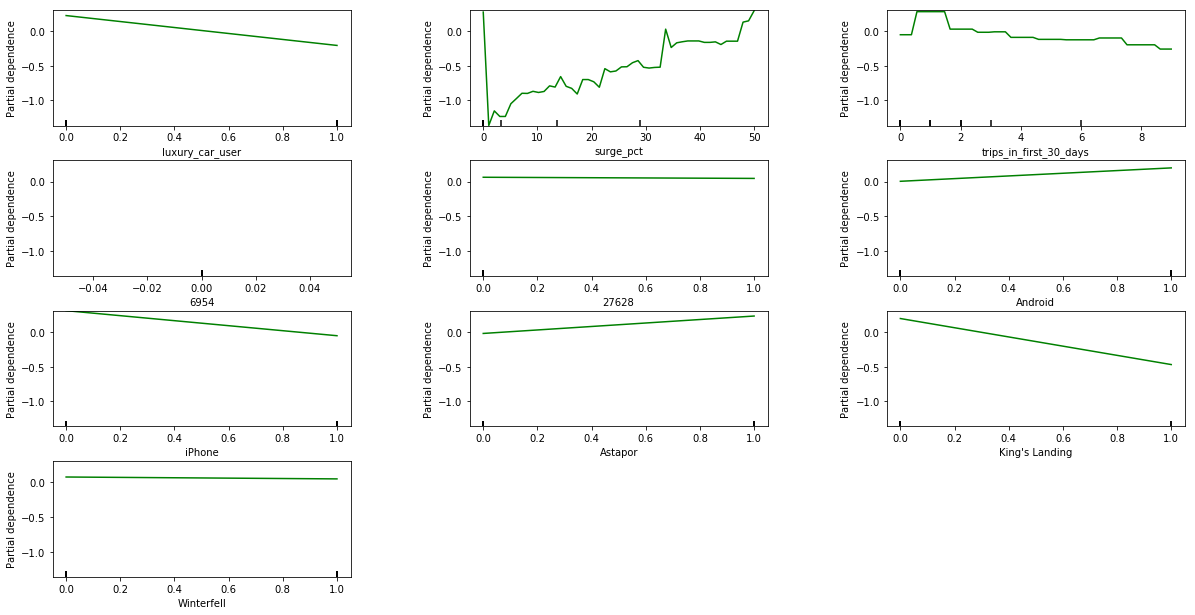

In [152]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
names = X_train_round1.columns

features = [0,1,2,3,4,5,6,7,8,9]
fig, axs = plot_partial_dependence(best_gbclf_model, X_train_round1, features,
                                       feature_names=names,
                                       n_jobs=3, grid_resolution=50)
fig.set_size_inches(18.5, 10.5, forward=True)
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle